# Disaster Tweet Prediction using RNN

In this Project I will use a recurrent neural network to predict whether or not a *tweet* is talking about a real disaster or not. To do this, I will use *Kaggle.com*'s competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started). <br>
**Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.**

**Requirements**
 - Keras's `TextVectorization` functionality must be used, although it need not be part of the model
 - `train.csv` should be split into training and validation sets 
 - the heart of  model must only use recurrent layers chosen from those [available in Keras](https://keras.io/api/layers/#recurrent-layers)
 - an embedding layer should be used; this can be learned along with the main task or use the [GloVe](https://github.com/stanfordnlp/GloVe) or [word2vec]() pretrained word embeddings
 - the evaluation metric for this dataset is the [F1-Score](https://www.kaggle.com/c/nlp-getting-started/overview/evaluation)

In [1]:
#Loading required libraries
import numpy as np                               # linear algebra
import pandas as pd                              # data processing, CSV file I/O (e.g. pd.read_csv)

import re                                        # to handle regular expressions
from string import punctuation                   # to extract the puntuation symbols

from nltk.tokenize import word_tokenize          # to divide strings into tokens
from nltk.stem import WordNetLemmatizer          # to lemmatize the tokens
from nltk.corpus import stopwords                # to remove the stopwords 

import random                                    # for generating (pseudo-)random numbers
import matplotlib.pyplot as plt                  # to plot some visualizations

import tensorflow as tf            
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train_data = pd.read_csv("nlp-getting-started/train.csv")
test_data  = pd.read_csv("nlp-getting-started/test.csv")

In [3]:
pd.options.display.max_colwidth = 300   # to show the whole tweets

print("Example of a real tweet: \n" +train_data[train_data['target']==1].sample()['text'].values[0])
print("*"*100)
print("Example of a fake tweet: \n" +train_data[train_data['target']==0].sample()['text'].values[0])

Example of a real tweet: 
b/c it costs less to have sick people using emergency rooms?...grrrr.... http://t.co/vFbbcHwrFD
****************************************************************************************************
Example of a fake tweet: 
Set goals &amp; DEMOLISH them all! ?


In [4]:
# cleaning the text

def clean_text(text):
    '''Make text lowercase, remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and train datasets
train_data['text'] = train_data['text'].apply(lambda x: clean_text(x))
test_data['text'] = test_data['text'].apply(lambda x: clean_text(x))

In [5]:
# tokenizing the text

train_data['text'] = train_data['text'].apply(lambda x:word_tokenize(x))
test_data['text'] = test_data['text'].apply(lambda x:word_tokenize(x))

In [6]:
# removing stopwords (defined in nltk.corpus.stopwords)

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words 
# Applying the removing stopwords function to both test and train datasets
train_data['text'] = train_data['text'].apply(lambda x : remove_stopwords(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_stopwords(x))

In [7]:
# lemmatizing the text entries

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text] 

# Applying the lemmatize_text function to both test and train datasets
train_data['text'] = train_data['text'].apply(lambda x : lemmatize_text(x))
test_data['text'] = test_data['text'].apply(lambda x : lemmatize_text(x))

In [8]:
# converting list of strings into joint strings

def concatenate_text(text):
    return ' '.join(text)

train_data['text'] = train_data['text'].apply(lambda x : concatenate_text(x))
test_data['text'] = test_data['text'].apply(lambda x : concatenate_text(x))

In [9]:
train_data.sample(5)

,id,keyword,location,text,target
1329,1920,burning,NaN,last day summer supposed fun whats fun accidentally burning arm hair playing w lighter,0
1568,2265,cliff%20fall,NaN,youre reading go accidentally fall cliff mate,0
5040,7186,mudslide,NaN,called mudslide aw,0
430,623,arsonist,"Adelaide, South Australia",arsonist blamed blaze plastic recycling business adelaide report,0
4050,5753,forest%20fires,NaN,reddit lightning spark new fire boise national forest rstormcoming,1


### Importing the GloVe embeddings

Global Vector (GloVe) is the world embedding technique that uses the word to word cooccurance statistics from a large corpus.
Here I have used downloaded version of the GloVe file and used for world embedding.

In [10]:

embeddings_index = {}

f = open('glove.6B.100d.txt/glove.6B.100d.txt',encoding="utf8")
for line in f:
    splitLine = line.split(' ')
    word = splitLine[0]                                  # the first entry is the word
    coefs = np.asarray(splitLine[1:], dtype='float32')   # these are the vectors representing word embeddings
    embeddings_index[word] = coefs
print("Glove data loaded! In total:",len(embeddings_index)," words.")

Glove data loaded! In total: 400000  words.


Here, I have loaded the 400000 words and their 300- dimensional representation.

### Next, I am going to build some helper functions. The first one randomly divides the dataframe into two subsamples, for training and validation, respectively.

In [11]:
def train_val_split(df, validation_split):
    """
    This function generates the training and validation splits from an input dataframe and which returns:
        train_samples: list of strings in the training dataset
        val_samples: list of strings in the validation dataset
        train_labels: list of labels (0 or 1) in the training dataset
        val_labels: list of labels (0 or 1) in the validation dataset      
    """
       
    text = df['text'].values.tolist()                         
    targets = df['target'].values.tolist()                   
    
#   Getting the training/validation datasets
    
    seed = random.randint(1,50)   # random integer in a range (1, 50)
    rng = np.random.RandomState(seed)
    rng.shuffle(text)
    rng = np.random.RandomState(seed)
    rng.shuffle(targets)

    num_validation_samples = int(validation_split * len(text))

    train_samples = text[:-num_validation_samples]
    val_samples = text[-num_validation_samples:]
    train_labels = targets[:-num_validation_samples]
    val_labels = targets[-num_validation_samples:]
    
    print(f"Total size of the dataset: {df.shape[0]}.")
    print(f"Training dataset: {len(train_samples)}.")
    print(f"Validation dataset: {len(val_samples)}.")
    
    return train_samples, val_samples, train_labels, val_labels

In [12]:
train_samples, val_samples, train_labels, val_labels = train_val_split(train_data, 0.1)

Total size of the dataset: 7613.
Training dataset: 6852.
Validation dataset: 761.


### In the following steps I have used `TextVectorization` layer. And  I have also created an embedding matrix. In this case, the embedding matrix is N-by-300 matrix, where N is the total count of distinct words in the input dataframe. If the word is not found in the embeddings_index, then the corresponding column is all-zeroes

In [13]:
def make_embedding_matrix(train_samples, val_samples, embeddings_index):
    """
    This function computes the embedding matrix that will be used in the embedding layer
    
    Parameters:
        train_samples: list of strings in the training dataset
        val_samples: list of strings in the validation dataset
        embeddings_index: Python dictionary with word embeddings
    
    Returns:
        embedding_matrix: embedding matrix with the dimensions (num_tokens, embedding_dim), where num_tokens is the vocabulary of the input data,
        and emdebbing_dim is the number of components in the GloVe vectors.
        vectorizer: TextVectorization layer      
    """
    
    vectorizer = TextVectorization(max_tokens=30000, output_sequence_length=50)
    text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
    vectorizer.adapt(text_ds)
    
    voc = vectorizer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))
      
    num_tokens = len(voc)
    
    hits = 0
    misses = 0

#   creating an embedding matrix
    embedding_dim = len(embeddings_index['the'])
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
            
    print(f"Converted {hits} words ({misses} misses).")

    return embedding_matrix, vectorizer

In [14]:
embedding_matrix, vectorizer = make_embedding_matrix(train_samples, val_samples, embeddings_index)

Converted 9831 words (4590 misses).



### In the following steps I have initialized the keras model for training purpose, the architecture of the model is Embedding layer, Dropout, LSTM, Conv1D, GlobalMaxPooling1D, Dense and Output.

In [15]:
def initialize_nn(embedding_matrix):
    """
    This function initializes Keras model for binary text classification
    
    Parameters:
        embedding matrix with the dimensions (num_tokens, embedding_dim), where num_tokens is the vocabulary size of the input data, and emdebbing_dim is the number of components in the GloVe vectors
    
    Returns:
        model: Keras model    
    """
    
    num_tokens = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    
    embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,          
    )
    
#   Here we define the architecture of the Keras model. 
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer(int_sequences_input) 
    x = layers.Dropout(0.5)(x)
    x = layers.LSTM(128,return_sequences=True)(x)
    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    preds = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(int_sequences_input, preds)
    
    return model

In [16]:
initial_model = initialize_nn(embedding_matrix)
initial_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1442100   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         49280     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [17]:
def train_nn(model, train_samples, val_samples, train_labels, val_labels, vectorizer, stop = False):
    """
    This function fits the training data using validation data to calculate metrics.
    
    Parameters:
        model: preinitialized Keras model
        train_samples: list of strings in the training dataset
        val_samples: list of strings in the validation dataset
        train_labels: list of labels (0 or 1) in the training dataset
        val_labels: list of labels (0 or 1) in the validation dataset
        vectorizer: TextVectorization layer
        stop (Boolean): flag for Early Stopping (aborting training when a monitored metric has stopped improving)
    
    Returns:
        model: trained Keras model
        history: callback that can be used to track the learning process
    """
    
    print('')
    print("Training the model...")
    
    model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["acc"])
    
    x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
    x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
    
    y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
    y_val = np.asarray(val_labels).astype('float32').reshape((-1,1))
    
    if stop:
        early_stopping = EarlyStopping(monitor='val_loss', patience=1)
        history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
    else:
        history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), verbose=1)
        
    return model, history

In [18]:
model, history = train_nn(initial_model, train_samples, val_samples, train_labels, val_labels, vectorizer, stop=False)


Training the model...
Epoch 1/20
215/215 [==============================] - 12s 54ms/step - loss: 0.5167 - acc: 0.7545 - val_loss: 0.5003 - val_acc: 0.7858
Epoch 2/20
215/215 [==============================] - 11s 49ms/step - loss: 0.4760 - acc: 0.7802 - val_loss: 0.4748 - val_acc: 0.7779
Epoch 3/20
215/215 [==============================] - 11s 52ms/step - loss: 0.4674 - acc: 0.7888 - val_loss: 0.4852 - val_acc: 0.7819
Epoch 4/20
215/215 [==============================] - 12s 57ms/step - loss: 0.4497 - acc: 0.7973 - val_loss: 0.4603 - val_acc: 0.7950
Epoch 5/20
215/215 [==============================] - 11s 50ms/step - loss: 0.4419 - acc: 0.7910 - val_loss: 0.4605 - val_acc: 0.7766
Epoch 6/20
215/215 [==============================] - 11s 52ms/step - loss: 0.4343 - acc: 0.8017 - val_loss: 0.4635 - val_acc: 0.7898
Epoch 7/20
215/215 [==============================] - 13s 58ms/step - loss: 0.4184 - acc: 0.8180 - val_loss: 0.5181 - val_acc: 0.7622
Epoch 8/20
215/215 [===================

In [19]:
# here I define a function to plot the history of Keras model training

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)    
    ax1.plot(x, acc, 'b', label='Training acc')
    ax1.plot(x, val_acc, 'r', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_ylim(0,1)
    ax1.legend()
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x, loss, 'b', label='Training loss')
    ax2.plot(x, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.legend()

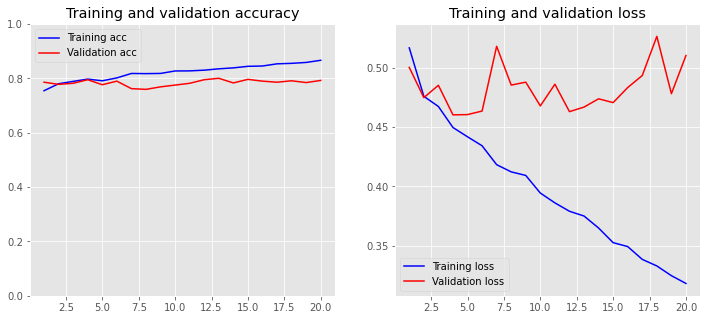

In [20]:
plot_history(history)

### As seen in the above figure, the training accuracy of the model seems increased as number of epoch increases, however, the validation accuracy increased at first and it remains steady for some range of epoch and then started to decline. Which clearly shows the sign of overfitting, in order to overcome this issues I have used early stopping method.

In [21]:
train_samples, val_samples, train_labels, val_labels = train_val_split(train_data, validation_split = 0.1)

embedding_matrix, vectorizer = make_embedding_matrix(train_samples, val_samples, embeddings_index)

initial_model = initialize_nn(embedding_matrix)

model, history = train_nn(initial_model, train_samples, val_samples, train_labels, val_labels, vectorizer, stop=True)

Total size of the dataset: 7613.
Training dataset: 6852.
Validation dataset: 761.
Converted 9904 words (4592 misses).

Training the model...
Epoch 1/20
215/215 [==============================] - 13s 60ms/step - loss: 0.5192 - acc: 0.7529 - val_loss: 0.4535 - val_acc: 0.7924
Epoch 2/20
215/215 [==============================] - 10s 45ms/step - loss: 0.4731 - acc: 0.7824 - val_loss: 0.4408 - val_acc: 0.7924
Epoch 3/20
215/215 [==============================] - 10s 47ms/step - loss: 0.4696 - acc: 0.7858 - val_loss: 0.4407 - val_acc: 0.7924
Epoch 4/20
215/215 [==============================] - 11s 52ms/step - loss: 0.4517 - acc: 0.7982 - val_loss: 0.4286 - val_acc: 0.7989
Epoch 5/20
215/215 [==============================] - 11s 52ms/step - loss: 0.4398 - acc: 0.7995 - val_loss: 0.4272 - val_acc: 0.8042
Epoch 6/20
215/215 [==============================] - 11s 53ms/step - loss: 0.4286 - acc: 0.8065 - val_loss: 0.4320 - val_acc: 0.8095


### Finally, I have used following method to make predictions on the previously unseen data.

In [43]:
def suggest_nn(df, model):
    """
    This function generates (binary) targets from a dataframe with column "text" using trained Keras model
    
    Parameters:
        df: pandas dataframe with column "text"
        model: Keras model (trained)
    
    Output:
        predictions: list of suggested targets corresponding to string entries from the column "text"
    """
    
    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorizer(string_input)
    preds = model(x)
    end_to_end_model = keras.Model(string_input, preds)

    probabilities = end_to_end_model.predict(df["text"])
    
    predictions = [1 if i > 0.5 else 0 for i in probabilities]
    
    return predictions

In [44]:
# Step to generate Submission.csv
predictions = suggest_nn(test_data, model)

submission_data = {"ID": test_data.id.tolist(), "target": predictions}

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv('submission.csv', index=False)

In [71]:
submission_df.head()

,ID,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [82]:
# Saving final model
model.save("Disaster_Model.keras")